Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats
import pingouin as pg
import statistics
import plotly.graph_objects as go
import plotly.express as px 
import plotly.io as pio

In [ ]:
# Set the filepath and other variables
filepath = '/home/rajat_joshi/Documents/lab/tES/experiment/SRTT_SEPARATE/'
outliers = ['SUBC3FP2010', 'SUBC3FP2054']
blocks = ['Block' + str(i+1) for i in range(8)]

# Initialize data containers
block_mean = pd.DataFrame(index=blocks)
block_norm_cent_mean = pd.DataFrame(index=blocks)
block_rt_abs_mean = pd.DataFrame(index=blocks)
block_std = pd.DataFrame(index=blocks)
block_rt_abs_std = pd.DataFrame(index=blocks)
block_rt_abs_er = pd.DataFrame(index=blocks)
block_err = pd.DataFrame(index=blocks)
block_norm_cent_err = pd.DataFrame(index=blocks)
data_files_full = dict()
variability_sub_all_blocks = dict()
data_files = dict()
data_file_cent = dict()
upper_bound = dict()
lower_bound = dict()
error_dict_full = dict()
error_dict_block = dict()
block_er_mean = pd.DataFrame(index=blocks)
block_er_mean_norm = pd.DataFrame(index=blocks)
block_er_sem = pd.DataFrame(index=blocks)
block_er_sem_norm = pd.DataFrame(index=blocks)
anova_file_full = []
final_VAR_file = dict()
an_learn = []
an_learn_cond = []
an_learn_sub = []
an_learn_nn = []
data_files_abs = dict()
learn_dict = dict()
learn_full = []
learn_df = pd.DataFrame()
data_files_absRT = dict()
data_file_absRT_sub = dict()
total_correct_df = pd.DataFrame()
timeDuration_df = pd.DataFrame()

# Get the list of files in the filepath
filepaths = os.listdir(filepath)
order = [0, 2, 1]
filepaths = [filepaths[i] for i in order]

# Iterate over filepaths
for file in filepaths:
    # Get the list of files in the current directory
    files = os.listdir(filepath + file + '/')
    
    # Exclude outliers from the file list
    files_except_outliers = [i for i in files if i[:11] not in outliers]
    
    # Initialize data containers
    final = pd.DataFrame(index=blocks)
    final_cent = pd.DataFrame(index=blocks)
    final_er_norm = pd.DataFrame(index=blocks)
    final_er = pd.DataFrame(index=blocks)
    final_er_full = pd.DataFrame(index=['all'])
    final_abs = pd.DataFrame(index=blocks)
    final_var = pd.DataFrame(index=blocks)
    total_correct = []
    timeDuration = []

    # Iterate over files in the current directory
    for indexx, i in enumerate(files_except_outliers):
        # Initialize data containers for the current file
        anova_file = pd.DataFrame()
        filename = i[:13]
        
        # Determine the skip rows based on the filename
        if filename[-1] == '1':
            skip_r = 2957
        else:
            skip_r = 2896

        # Read the CSV file
        df = pd.read_csv(filepath + file + '/' + i, skiprows=skip_r, delimiter="\t")

        # Process the data
        df1 = df[df["Code"].str.len() > 5]  # To separate nan and isi from block

        df1[["Block", "Condition", "Target Button", "Trial Number"]] = df1["Code"].str.split(';', expand=True)
        df1.drop("Code", axis=1, inplace=True)
        cols = ["Block", "Condition", "Target Button", "Trial Number"]

        for col in reversed(cols):
            temp = df1[col].str.strip()
            df1.drop(labels=[col], axis=1, inplace=True)
            df1.insert(1, col, temp)

        cols.remove("Condition")
        df1 = df1[df1['Block'] != 'PRACTICE BLOCK']  # Removing practice blocks
        for col in cols:
            df1[col] = df1[col].str.extract('(\d+)').astype(int)  # Extract numbers from string
        df1["RT"] = df1["RT"] / 10

        # Remove incorrect trials and calculate error rates
        incorrect = df1[df1["Type"] == "incorrect"]
        hit = df1[df1["Type"] == "hit"]
        blockwise_before_drop = hit.groupby("Block").size().reset_index()
        blockwise_before_drop.drop('Block', axis=1, inplace=True)
        final_er['er_'+filename] = 1 - (blockwise_before_drop.to_numpy() / 120)
        final_er_full['er_'+filename] = 1 - (len(hit) / len(df1))
        total_correct.append(len(hit))
        time = hit["Time"].tolist()
        timeDuration.append(time[-1] / 60 / 10000)

        # Remove outliers based on RT mean and standard deviation
        RT_mean = hit["RT"].mean()
        RT_std = hit["RT"].std()
        hit.drop(hit[(hit["RT"] > (RT_mean + 3 * RT_std))].index, inplace=True)
        
        # Calculate blockwise mean and normalize the values
        blockwise = hit.groupby("Block")["RT"].mean().reset_index()
        blockwise['normal'] = blockwise['RT'] / blockwise.iloc[0]['RT']
        final['norm_'+filename] = blockwise['normal'].to_numpy()

        # Calculate implicit learning and percent increase across blocks
        learn = blockwise.iloc[5]['normal'] - blockwise.iloc[4]['normal']
        learn_nn = blockwise.iloc[7]['RT'] - blockwise.iloc[2]['RT']
        norm_cent = []

        for index, row in blockwise.iterrows():
            if index == 0:
                norm_cent.append(0)
            else:
                norm_cent.append((float(row["RT"]) - float(blockwise.iloc[index-1]['RT'])) /
                                 abs(float(blockwise.iloc[index-1]['RT'])))

        blockwise["norm_cent"] = norm_cent
        blockwise['var'] = statistics.variance(blockwise['RT'])
        blockwise['var_norm'] = abs(blockwise['normal'] - (blockwise['normal'].mean()))
        final_var[filename] = blockwise['var'].to_numpy()
        blockwise['ER'] = final_er.mean(axis=1).to_numpy()
        blockwise['ER_norm'] = blockwise['ER'] / blockwise.iloc[0]['ER']
        final_er_norm['er_norm_'+filename] = blockwise['ER_norm'].to_numpy()
        final_abs['rt_abs_'+filename] = blockwise['RT'].to_numpy()
        final_cent["RT_change"] = blockwise["norm_cent"].to_numpy()
        an_learn.append(learn)
        an_learn_nn.append(learn_nn)
        an_learn_cond.append(file)
        an_learn_sub.append(filename[-4:-2])

        learn_df = pd.DataFrame()
        learn_df["subject"] = [filename[-4:-2]]
        learn_df['learn'] = learn
        learn_df["learn_nn"] = learn_nn
        learn_df["cond"] = file
        learn_full.append(learn_df)

        anova_file['subject'] = [filename[-4:-2]] * len(blocks)
        anova_file['rt_abs'] = blockwise['RT'].to_numpy()
        anova_file['norm_rt'] = blockwise['normal'].to_numpy()
        anova_file['er'] = blockwise['ER'].to_numpy()
        anova_file['var'] = blockwise['var'].to_numpy()
        anova_file['var_norm'] = blockwise['var_norm'].to_numpy()
        anova_file['block'] = blocks
        anova_file['condition'] = file
        anova_file['norm_cent'] = blockwise["norm_cent"]
        anova_file_full.append(anova_file)

    # Store the calculated results in the respective data containers
    q1 = final.quantile(.25, axis=1)
    q3 = final.quantile(.75, axis=1)
    iqr = q3 - q1
    upper_bound[file] = q3 + (1.5 * iqr)
    lower_bound[file] = q1 - (1.5 * iqr)
    data_files[file] = final.loc[['Block5', 'Block6', 'Block8']].T
    data_files_absRT[file] = final_abs.loc[['Block5', 'Block6', 'Block8']].T
    data_files_full[file] = final
    data_file_absRT_sub[file] = final_abs
    final_VAR_file[file] = final_var
    data_file_cent[file] = final_cent
    block_mean[file] = final.mean(axis=1)
    block_norm_cent_mean[file] = final_cent.mean(axis=1)
    block_er_mean_norm[file] = final_er_norm.mean(axis=1)
    block_rt_abs_mean[file] = final_abs.mean(axis=1)
    block_std[file] = final.std(axis=1)
    block_rt_abs_std[file] = final_abs.std(axis=1)
    block_err[file] = final.sem(axis=1)  # standard error of mean
    block_norm_cent_err[file] = final_cent.sem(axis=1)
    block_er_sem_norm[file] = final_er_norm.sem(axis=1)
    block_rt_abs_er[file] = final_abs.sem(axis=1)
    error_dict_block[file] = final_er
    block_er_mean[file] = final_er.mean(axis=1)
    block_er_sem[file] = final_er.sem(axis=1)
    error_dict_full[file] = final_er_full
    data_files_abs[file] = final_abs
    total_correct_df[file] = total_correct
    timeDuration_df[file] = timeDuration


Generating csvs for ANOVA

In [3]:
an_file = pd.concat(anova_file_full)
learn_file = pd.concat(learn_full)
anova_learn = pd.DataFrame({'Subject': an_learn_sub, 'learning':an_learn, 'learning_nn': an_learn_nn, 'condition': an_learn_cond})
# an_file.to_csv(r"/an_file_session.csv") 

In [4]:
learn_cond = anova_learn.groupby('condition')['learning'].apply(list).to_dict()
learn_cond_nn = anova_learn.groupby('condition')['learning_nn'].apply(list).to_dict()
er_ = an_file.groupby('block')['er'].apply(list).to_dict()
# learn_cond.set_index("condition")
anova_learn.set_index("Subject",drop = "index", inplace = True)
anova_learn.sort_index(inplace = True)
# anova_learn.to_csv(r"/anova_learn.csv")

Comparing block 1 data across the stimulation conditions

In [5]:
block1Df = pd.DataFrame({"Sham" : data_files_abs["Sham"].iloc[0,:].to_numpy(),
                         "Fixed dose" : data_files_abs["Fixed dose"].iloc[0,:].to_numpy(),
                         "Individualised dose" : data_files_abs["Individualised dose"].iloc[0,:].to_numpy()})
# block1Df.dropna()
# Performing ANOVA- Friedman test
result = pg.friedman(block1Df, method = "chisq")
print(result)

          Source         W  ddof1         Q     p-unc
Friedman  Within  0.063492      2  2.666667  0.263597


Descriptive statistics

In [6]:
# Total trials included in analysis
for i, row in total_correct_df.T.iterrows():
    print(i)
    print(" Mean:" + str(row.mean()))
    print(" SD:" + str(row.std()))
    print(" Min :" + str(min(row)))
    print(" Max :" + str(max(row)))
    print("")

Sham
 Mean:934.4285714285714
 SD:16.699016224231382
 Min :903
 Max :956

Fixed dose
 Mean:932.9047619047619
 SD:17.66325214082832
 Min :894
 Max :956

Individualised dose
 Mean:932.6666666666666
 SD:18.251940536100083
 Min :887
 Max :955



In [7]:
#Total stimulation time for each tDCS condition
for i, row in timeDuration_df.T.iterrows():
    print(i)
    print("Mean: " + str(row.mean()))
    print("SD: " + str(row.std()))
    print("")

Sham
Mean: 17.39729650793651
SD: 2.0787723111016154

Fixed dose
Mean: 17.005873968253972
SD: 2.275160481655359

Individualised dose
Mean: 17.009117380952382
SD: 1.6434841258670023



z_score across blocks

In [44]:
# inter subject z- score
for key in data_files_full:
    mean_block_1 = data_files_full[key].loc["Block2"].mean()
    z_score = (data_files_full[key].T - data_files_full[key].T.mean()) / data_files_full[key].T.std()
    std_blockwise = data_files_full[key].std(axis = 1)
    fig = px.strip(z_score, hover_name = z_score.index.str[-4:-2])
    fig.update_layout(yaxis_title=key)
    fig.show()

Analysing the baseline performance

In [14]:
b1_sham_abs_gtr_1mA =data_files_abs['Sham'].iloc[0]  #sham cond baseline >1mA

In [15]:
b1_sham_abs_less_1mA = data_files_abs['Sham'].iloc[0] #sham condi baseline <1

In [ ]:
test, p = shapiro(b1_sham_abs_gtr_1mA) #testing for normality
print("Shapiro "+"statistics=" + str(test), "p_value=" + str(p))
stats.levene(b1_sham_abs_gtr_1mA, b1_sham_abs_less_1mA)

In [ ]:
# t-test between the >1mA and <1mA ; equal_var = False- Welch t test, bc sample size differs 
print(stats.ttest_ind(b1_sham_abs_gtr_1mA, b1_sham_abs_less_1mA, equal_var= False)) 

# Effect size for Gtr::less
cohens_d = (statistics.mean(b1_sham_abs_gtr_1mA) - statistics.mean(b1_sham_abs_less_1mA)) / (statistics.sqrt((statistics.stdev(b1_sham_abs_gtr_1mA) ** 2 + statistics.stdev(b1_sham_abs_less_1mA) ** 2) / 2))
print("Cohens_d= " + str(round(cohens_d, 4)))

#DOF
varGtr = statistics.variance(b1_sham_abs_gtr_1mA)
varLess = statistics.variance(b1_sham_abs_less_1mA)

dof = (varGtr/len(b1_sham_abs_gtr_1mA) + varLess/len(b1_sham_abs_less_1mA))**2 / (((varGtr/len(b1_sham_abs_gtr_1mA))**2)/(len(b1_sham_abs_gtr_1mA)-1) + ((varLess/len(b1_sham_abs_less_1mA))**2)/(len(b1_sham_abs_less_1mA)-1))
print("Deegree of freedom= " + str(dof))

Plotting figures

In [ ]:
# Baseline performance for the >1mA::<1mA
fig,ax = plt.subplots(figsize = ((15,10)))
data_to_plot = [b1_sham_abs_gtr_1mA, b1_sham_abs_less_1mA]
ax.boxplot(data_to_plot, patch_artist=True, )
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '<1mA'
labels[0] = '>1mA'
ax.set_xticklabels(labels)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.grid(True, axis = "y", color='w', linestyle='-', linewidth=2)
plt.gca().patch.set_facecolor('#f0f9ff')
plt.ylim(250,650)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23) 
plt.rc('axes', titlesize=30)   
plt.rc('axes', labelsize=22)
plt.xlabel('Stimulation dose (mA)', fontsize = 26, fontname = "sans-serif")
plt.ylabel('RT (ms)', fontsize = 26, fontname = "sans-serif")
plt.title('BASELINE PERFORMANCE - Sham Block1', fontsize = 30, fontname = "sans-serif")

from matplotlib.markers import TICKDOWN

def significance_bar(start,end,height,displaystring,linewidth = 1.2,
    markersize = 8,boxpad  =0.5,fontsize = 20,color = 'k'):
    # draw a line with downticks at the ends
    ax.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker=TICKDOWN, 
    markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    ax.text(0.5*(start+end),height+5,displaystring,ha = 'center',va='center',
    bbox=dict(alpha = 0,facecolor='1', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

p_val = 0.011934

for ind, row in statTable.iterrows():
    p = p_val
    if p>=0.05:
        displaystring = r'n.s.'
    elif p<0.0001:
        displaystring = r'***'
    elif p<0.001:
        displaystring = r'**'
    else:
        displaystring = r'*'
    height = max(baseline["Abs_RT"])+15

significance_bar(1, 2,height,displaystring)
# fig.savefig(r"/baselinePerformance.jpg", format="jpg", dpi = 500)
plt.show()

Text(0.5, 0.999, 'Absolute RT')

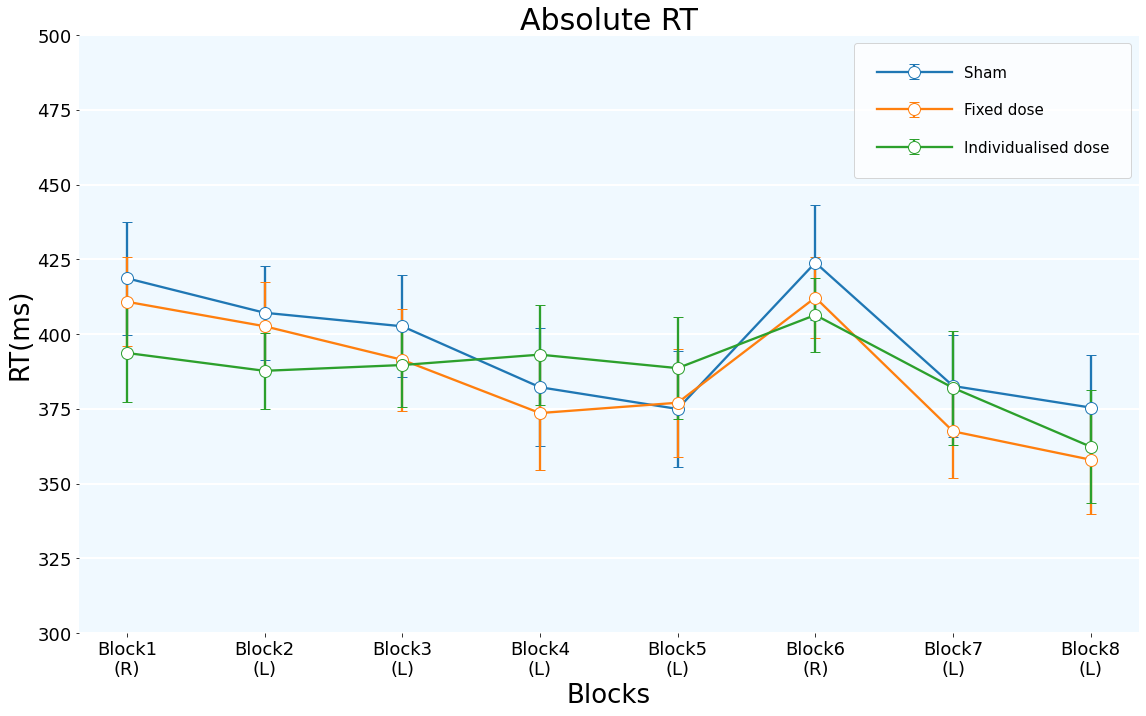

In [31]:
# Blockwise behavioural performance
## Absolute Reaction time
ax = block_rt_abs_mean.plot(yerr = block_rt_abs_er, ylim=[300, 500],
    figsize = (19,11), capsize = 5, linewidth = 2.3, 
    marker = 'o', markersize = 12, markerfacecolor = 'white' )

ax.legend(loc = "upper right", borderpad=1.5, labelspacing=1.5, handlelength=5,
    prop = {"size":15 })
# ax.set_frame_on(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
xTickPos = [0, 1, 2, 3,4,  5 ,6 ,7]
xTickName = ['Block1\n(R)', 'Block2\n(L)', 'Block3\n(L)', 'Block4\n(L)','Block5\n(L)',
    'Block6\n(R)','Block7\n(L)', 'Block8\n(L)']
plt.yticks(size = 18)
plt.xticks(xTickPos, labels = xTickName, size = 18)
plt.grid(True, axis = "y", color='w', linestyle='-', linewidth=2)
plt.gca().patch.set_facecolor('#f0f9ff')
plt.ylabel("RT(ms)", fontname = "sans-serif", size = 26)
plt.xlabel("Blocks", fontname = "sans-serif", size = 26)
plt.title("Absolute RT", fontname = "sans-serif",size = 30, y = 0.999)
# plt.savefig(r'/absoluteRT_sessions.jpg', format="jpg", dpi = 500)

Text(0.5, 0.999, 'Normalised RT')

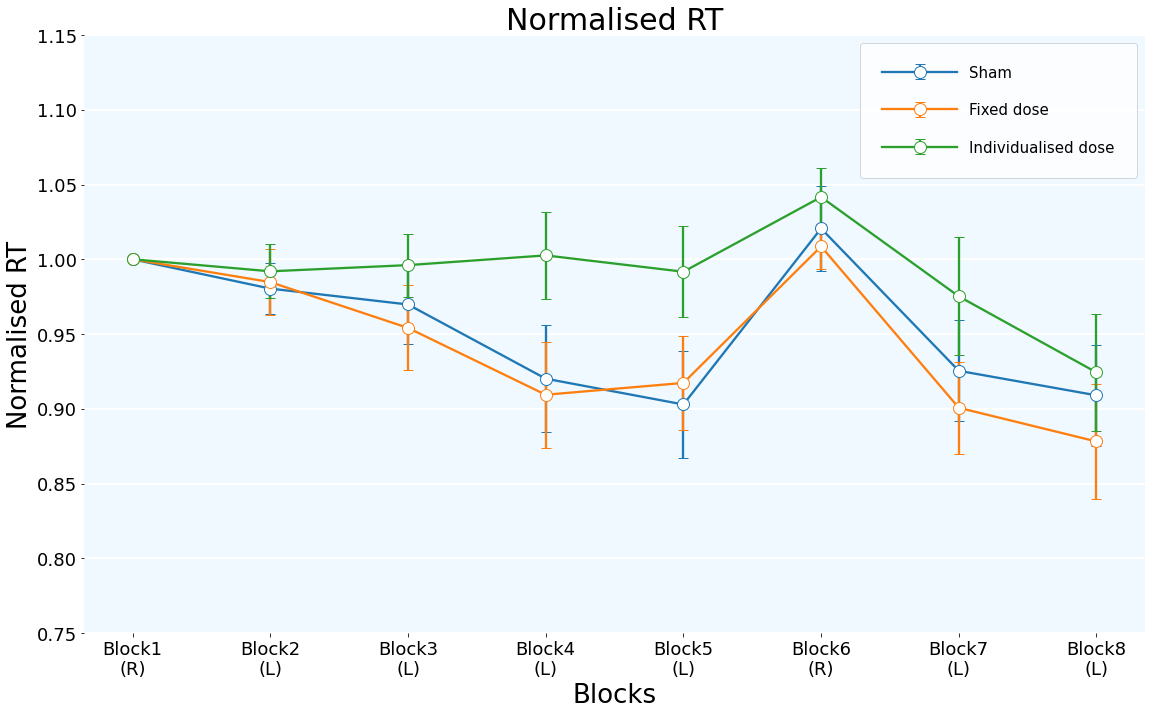

In [32]:
# Blockwise behavioural performance
## Normalised RT

ax = block_mean.plot(yerr = block_err, ylim=[0.75, 1.15],figsize = (19,11), capsize = 5, linewidth = 2.3, 
    marker = 'o', markersize = 12, markerfacecolor = 'white' ) #for poster linewidth = 4 otherwise 2.3; paper: figsize = (19,11)
ax.legend(loc = "upper right", borderpad=1.5, labelspacing=1.5, handlelength=5, prop = {"size":15})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
xTickPos = [0, 1, 2, 3,4,  5 ,6 ,7]
xTickName = ['Block1\n(R)', 'Block2\n(L)', 'Block3\n(L)', 'Block4\n(L)','Block5\n(L)',
    'Block6\n(R)','Block7\n(L)', 'Block8\n(L)']
plt.yticks(size = 18)
plt.xticks(xTickPos, labels = xTickName, size = 18)
plt.grid(True, axis = "y", color='w', linestyle='-', linewidth=2)
plt.gca().patch.set_facecolor('#f0f9ff') #check from previous cell for paper
plt.ylabel("Normalised RT", fontname = "sans-serif",size = 26)
plt.xlabel("Blocks", fontname = "sans-serif", size = 26)
plt.title("Normalised RT", fontname = "sans-serif",size = 30, y = 0.999)
# plt.savefig(r'/normalisedRT_sessions.jpg', format="jpg", dpi = 500)

Violin Plots
RT distribution: Fixed vs Individualised dose 

In [8]:
# Extract sub_list_ind and sub_list_fix
aa = data_files_full["Fixed dose"]
bb = data_files_full["Individualised dose"]
sub_list_ind = []
sub_list_ind = list(bb.T.index)
sub_list_fix = list(aa.T.index)

# Create long format data
data_lf = pd.melt(aa, value_vars=sub_list_fix, var_name="sub", value_name="RT")
data_lf["Blocks"] = ["Block1\n(R)", "Block2\n(L)", "Block3\n(L)", "Block4\n(L)", "Block5\n(L)", "Block6\n(R)",
                     "Block7\n(L)", "Block8\n(L)"] * 21
data_lf["cond"] = "Fixed"

data_lf2 = pd.melt(bb, value_vars=sub_list_ind, var_name="sub", value_name="RT")
data_lf2["Blocks"] = ["Block1\n(R)", "Block2\n(L)", "Block3\n(L)", "Block4\n(L)", "Block5\n(L)", "Block6\n(R)",
                      "Block7\n(L)", "Block8\n(L)"] * 21
data_lf2["cond"] = "Individualised"

df_plot = pd.concat([data_lf, data_lf2])

show_legend = [True, False, False, False, False, False, False, False]

fig = go.Figure()
blocks = pd.unique(df_plot['Blocks'])

for i, block in enumerate(blocks):
    fixed_cond = (df_plot['cond'] == 'Fixed') & (df_plot['Blocks'] == block)
    indiv_cond = (df_plot['cond'] == 'Individualised') & (df_plot['Blocks'] == block)

    fig.add_trace(go.Violin(x=df_plot['Blocks'][fixed_cond], y=df_plot['RT'][fixed_cond],
                            legendgroup='Fixed', scalegroup='Fixed', name='Fixed',
                            side='negative', pointpos=-1.07, line_color='lightseagreen',
                            showlegend=show_legend[i]))

    fig.add_trace(go.Violin(x=df_plot['Blocks'][indiv_cond], y=df_plot['RT'][indiv_cond],
                            legendgroup='Individualised', scalegroup='Individualised', name='Individualised',
                            side='positive', pointpos=1.1, line_color='mediumpurple',
                            showlegend=show_legend[i]))

# Update characteristics shared by all traces
fig.update_traces(meanline_visible=True, points='all', jitter=0.05, scalemode='count')

fig.update_layout(
    title_text="Behavioural Performance",
    yaxis_title='Normalized RT',
    violingap=0.3, violingroupgap=0, violinmode='overlay',
    autosize=False, width=1300, height=650, font_size=20, plot_bgcolor='#f0f9ff'
)
# pio.write_image(fig, r"/bimodal.jpg", scale = 12)
fig.show()

Bimodal distribution with sham

In [38]:
# Define function to calculate lower and upper adjacent values based on quartiles
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Define function to set axis style
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=18, fontname="sans")
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

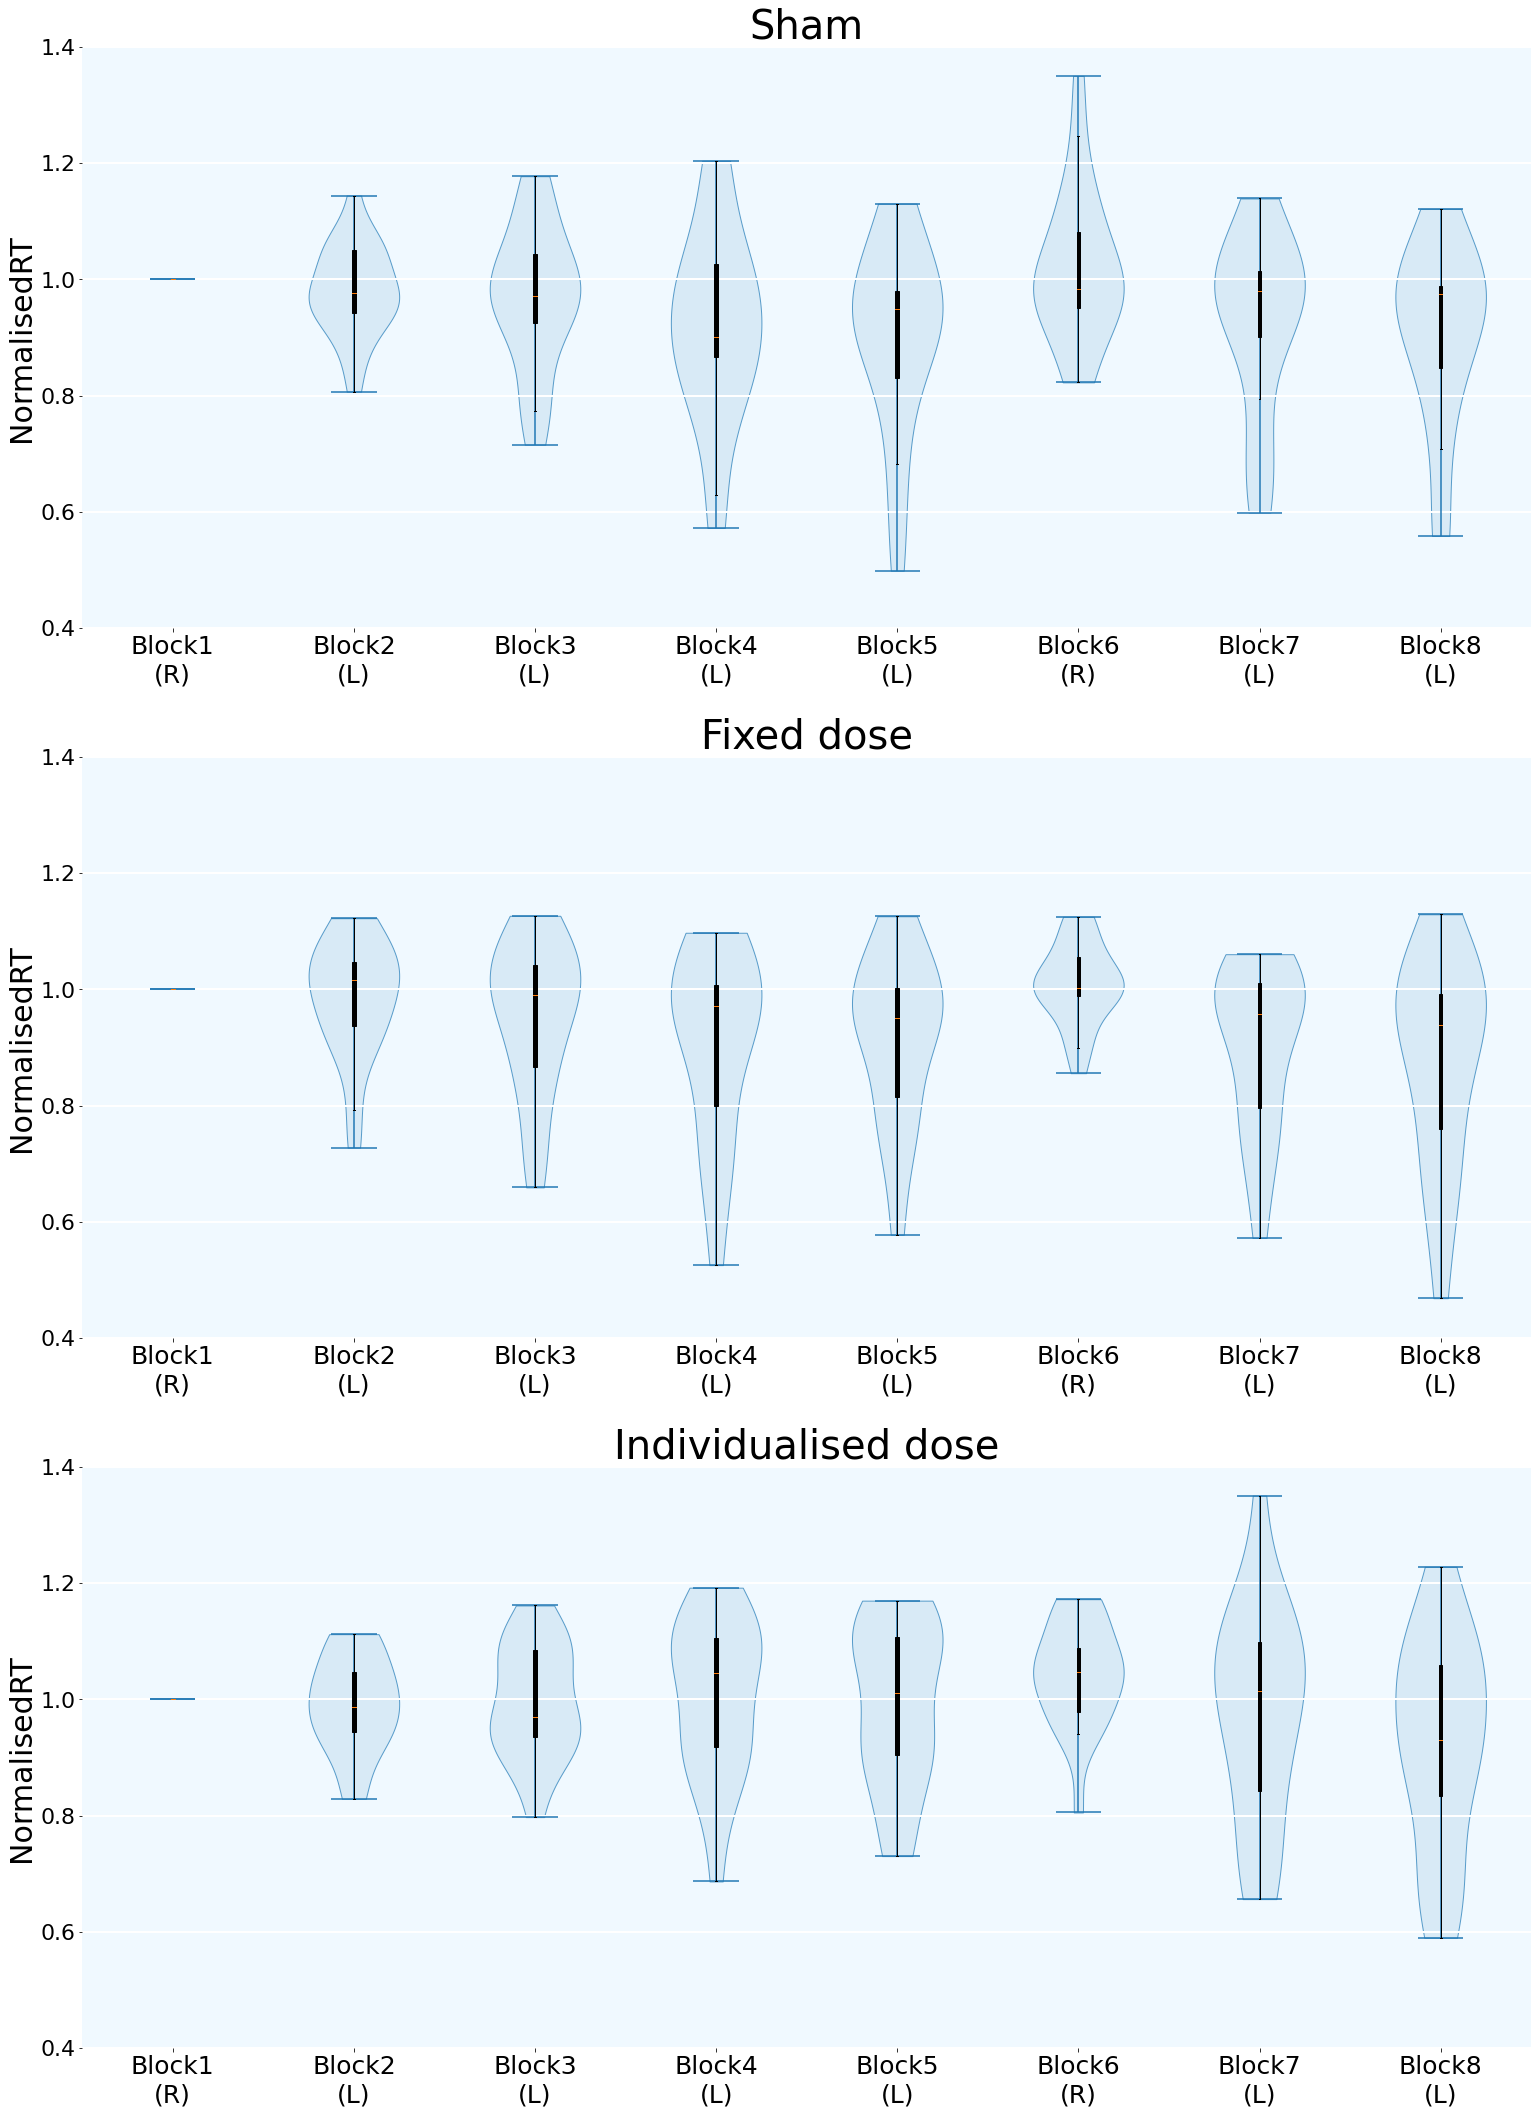

In [42]:
dataframes = [data_files_full['Sham'], data_files_full['Fixed dose'], data_files_full['Individualised dose']]
fig, axes = plt.subplots(nrows=len(dataframes), ncols=1, figsize=(22, 30), tight_layout={'pad': 3})
conditions = ['Sham', 'Fixed dose', 'Individualised dose']

# Iterate over dataframes and plot each row as a violin plot
for i, df in enumerate(dataframes):
    ax = axes[i]
    columns = df.columns
    data = df.to_numpy().T
    
    parts = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=True)
    
    # Set plot style and formatting
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.grid(True, axis='y', color='w', linestyle='-', linewidth=2, which="major", zorder=-1.0)
    ax.patch.set_facecolor('#f0f9ff')
    
    for pc in parts['bodies']:
        pc.set_facecolor('#cfe5f3')
        pc.set_edgecolor('#1d78b6')
        pc.set_alpha(0.7)
    
    ax.boxplot(data, widths=0.02, patch_artist=True, boxprops=dict(facecolor='black', edgecolor='black'),
               showfliers=False)
    
    ax.set_xticks(np.arange(1, len(data.T) + 1))
    ax.set_xticklabels(["Block1\n(R)", "Block2\n(L)", "Block3\n(L)", "Block4\n(L)", 
                        "Block5\n(L)", "Block6\n(R)", "Block7\n(L)", "Block8\n(L)"])
    
    ax.set_ylim(0.4, 1.4)
    ax.set_ylabel('NormalisedRT', fontsize=30, fontname="sans-serif")
    ax.set_title(conditions[i], fontsize=40, fontname="sans-serif")
    
    # Set font sizes
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=22)
    plt.rc('axes', titlesize=35)
    plt.rc('axes', labelsize=35)

    # Calculate quartiles and whiskers
    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
                         for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]



# plt.savefig("/bimodal_sham.jpg", format="jpg", dpi=500)
plt.show()
